In [161]:
import pandas as pd
import numpy as np

from math import sqrt

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

In [162]:
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)
G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)

candidates_MMAF = pd.read_pickle("./data/candidateGenesList_MMAF.p")

nonCandidates_MMAF = [n for n in list(G.nodes) if n not in candidates_MMAF]

In [163]:
# Eigenvector centrality is not defined for Multigraphs
type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph

False

In [164]:
def candidates_in_neighbourhood(G, candidates, node):
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G] if x in candidates]
    if candidates_in_neighbourhood:
        return candidates_in_neighbourhood
    else:
        return []

In [165]:
# modified version of eigenvector centrality that takes the number of candidates in the neighbourhood into account

def eigenvector_centrality_v1(G, max_iter=100, tol=1.0e-6, nstart=None, 
                           weight='weight'): 
    """
    Parameters 
    ---------- 
    G : graph 
      A networkx graph 
  
    max_iter : integer, optional 
      Maximum number of iterations in power method. 
  
    tol : float, optional 
      Error tolerance used to check convergence in power method iteration. 
  
    nstart : dictionary, optional 
      Starting value of eigenvector iteration for each node. 
  
    weight : None or string, optional 
      If None, all edge weights are considered equal. 
      Otherwise holds the name of the edge attribute used as weight.
    """
    if type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph: 
        raise nx.NetworkXException("Not defined for multigraphs.") 
  
    if len(G) == 0: 
        raise nx.NetworkXException("Empty graph.") 
  
    if nstart is None: 
        # choose starting vector with entries of 1/len(G) 
        x = dict([(n,1.0/len(G)) for n in G]) 
    else: 
        x = nstart 
  
    # normalize starting vector 
    s = 1.0/sum(x.values()) 
    for k in x: 
        x[k] *= s 
    nnodes = G.number_of_nodes() 
  
    # make up to max_iter iterations 
    for i in range(max_iter): 
        xlast = x 
        # x = dict.fromkeys(xlast, 0)
        x = dict([(n, len(candidates_in_neighbourhood(G, candidates_MMAF, n))) for n in list(G)])
  
        # do the multiplication y^T = x^T A 
        for n in x: 
            for nbr in G[n]: 
                x[nbr] += xlast[n] * G[n][nbr].get(weight, 1) 
  
        # normalize vector 
        try: 
            s = 1.0/sqrt(sum(v**2 for v in x.values())) 
  
        # this should never be zero? 
        except ZeroDivisionError: 
            s = 1.0
        for n in x: 
            x[n] *= s 
  
        # check convergence 
        err = sum([abs(x[n]-xlast[n]) for n in x]) 
        if err < nnodes*tol: 
            return x 
  
    raise nx.NetworkXError("""eigenvector_centrality(): 
power iteration failed to converge in %d iterations."%(i+1))""") 

In [166]:
# modified version of eigenvector centrality that takes the number of candidates in the neighbourhood into account

def eigenvector_centrality_v2(G, max_iter=100, tol=1.0e-6, nstart=None, 
                           weight='weight'): 
    """
    Parameters 
    ---------- 
    G : graph 
      A networkx graph 
  
    max_iter : integer, optional 
      Maximum number of iterations in power method. 
  
    tol : float, optional 
      Error tolerance used to check convergence in power method iteration. 
  
    nstart : dictionary, optional 
      Starting value of eigenvector iteration for each node. 
  
    weight : None or string, optional 
      If None, all edge weights are considered equal. 
      Otherwise holds the name of the edge attribute used as weight.
    """
    if type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph: 
        raise nx.NetworkXException("Not defined for multigraphs.") 
  
    if len(G) == 0: 
        raise nx.NetworkXException("Empty graph.") 
  
    if nstart is None: 
        # choose starting vector with entries of 1/len(G) 
        x = dict([(n,1.0/len(G)) for n in G]) 
    else: 
        x = nstart 
  
    # normalize starting vector 
    s = 1.0/sum(x.values()) 
    for k in x: 
        x[k] *= s 
    nnodes = G.number_of_nodes() 
  
    # make up to max_iter iterations 
    for i in range(max_iter): 
        xlast = x 
        # x = dict.fromkeys(xlast, 0)
        x = dict([(n, len(candidates_in_neighbourhood(G, candidates_MMAF, n))/G.degree(n)) for n in list(G)])
  
        # do the multiplication y^T = x^T A 
        for n in x: 
            for nbr in G[n]: 
                x[nbr] += xlast[n] * G[n][nbr].get(weight, 1) 
  
        # normalize vector 
        try: 
            s = 1.0/sqrt(sum(v**2 for v in x.values())) 
  
        # this should never be zero? 
        except ZeroDivisionError: 
            s = 1.0
        for n in x: 
            x[n] *= s 
  
        # check convergence 
        err = sum([abs(x[n]-xlast[n]) for n in x]) 
        if err < nnodes*tol: 
            return x 
  
    raise nx.NetworkXError("""eigenvector_centrality(): 
power iteration failed to converge in %d iterations."%(i+1))""") 

In [167]:
res = eigenvector_centrality(G)

In [169]:
res_sorted = dict(sorted(res.items(), key=lambda v: v[1], reverse=True))

In [140]:
evc_list = [v for k, v in res.items()]
min(evc_list), max(evc_list)

(5.1537618916549766e-107, 0.11355501782753011)

(0.0, 0.01)

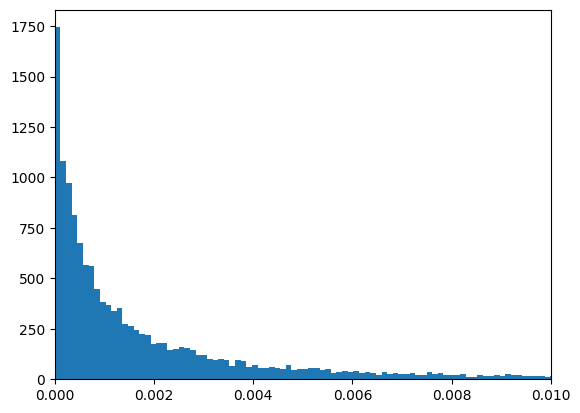

In [142]:
plt.hist(evc_list, bins=1000)
plt.xlim((0, 0.01))

In [143]:
max(evc_list)

0.11355501782753011

In [148]:
res_sorted.get('ENSG00000171135'), res_ev_sorted.get('ENSG00000171135')

(0.11355501782753011, 0.11416336936057032)

<Axes: xlabel='degree', ylabel='Eigenvector centrality'>

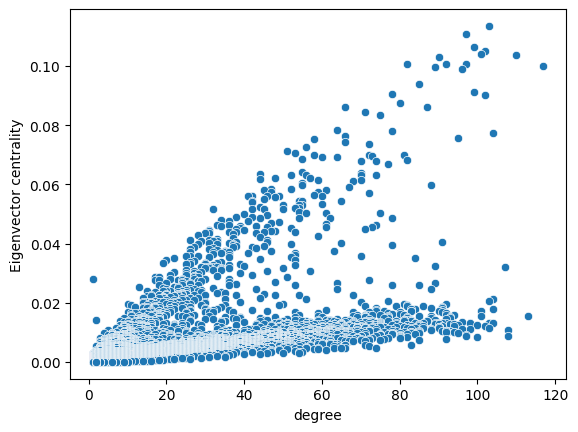

In [152]:
sns.scatterplot(data=df, x='degree', y='Eigenvector centrality')

In [160]:
# find eigenvalue centraility of candidate genes
for candidate in candidates_MMAF:
    print(candidate, res_sorted.get(candidate))

ENSG00000140057 None
ENSG00000118690 [0.00010546877693115491, 1]
ENSG00000284862 None
ENSG00000124721 [0.00028055886690491524, 1]
ENSG00000188738 [0.0001218558173347015, 1]
ENSG00000129646 [0.000936725686853148, 6]
ENSG00000130413 [0.0005021898813232045, 3]
ENSG00000137473 [0.027873846198839224, 1]
ENSG00000066185 [0.014066351594904332, 62]


### Calculate eigenvector centrality with Networkx

In [153]:
res_ev = nx.eigenvector_centrality(G)

In [154]:
res_ev_sorted = dict(sorted(res_ev.items(), key=lambda v: v[1], reverse=True))

In [155]:
res_ev_sorted.get('ENSG00000066185')

0.009088033481656014

Text(0.5, 1.0, 'Eigenvector centrality distribution')

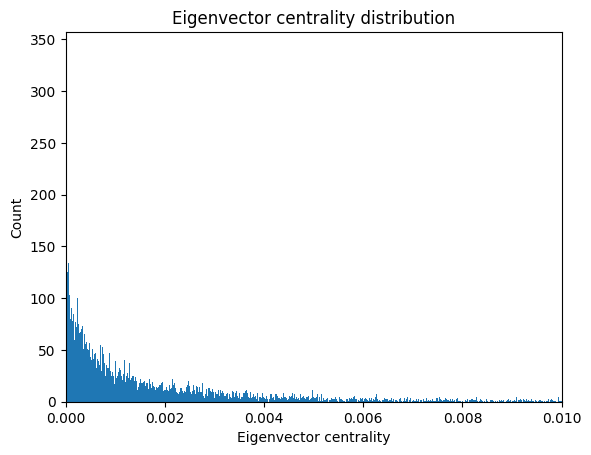

In [156]:
# plot eigenvector centrality distribution
res_ev_list = [v for k, v in res_ev_sorted.items()]
bins = len(set(res_ev_list))
plt.hist(res_ev_list, bins=bins)
plt.ylabel("Count")
plt.xlabel("Eigenvector centrality")
plt.xlim(0, 0.01)
plt.title("Eigenvector centrality distribution")

In [157]:
# eigenvector centrality vs. node degree
for k, v in res_ev_sorted.items():
    res_ev_sorted[k] = [v, G.degree(k)]
    
df = pd.DataFrame.from_dict(res_ev_sorted, orient='index', columns=['Eigenvector centrality', 'degree'])

In [158]:
df

,Eigenvector centrality,degree
ENSG00000171135,1.141634e-01,103
ENSG00000168958,1.113071e-01,97
ENSG00000166257,1.071704e-01,99
ENSG00000141699,1.056931e-01,102
ENSG00000126262,1.046357e-01,101
...,...,...
ENSG00000149043,2.644170e-86,2
ENSG00000166557,2.644170e-86,2
ENSG00000120332,2.644170e-86,2
ENSG00000146555,2.644170e-86,2


<Axes: xlabel='degree', ylabel='Eigenvector centrality'>

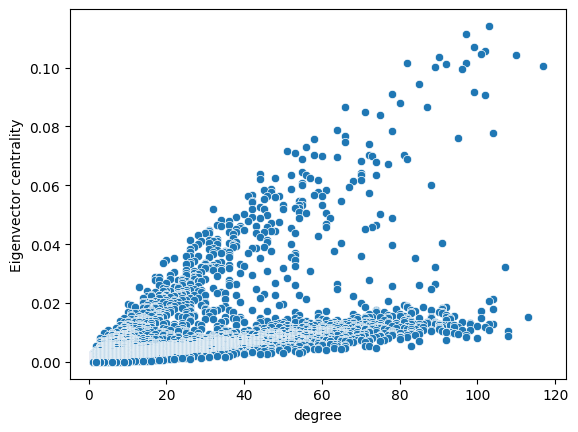

In [159]:
sns.scatterplot(data=df, x='degree', y='Eigenvector centrality')

In [12]:
# find eigenvalue centraility of candidate genes
for candidate in candidates_MMAF:
    print(candidate, res_ev_sorted.get(candidate))

ENSG00000140057 None
ENSG00000118690 [4.602963248847219e-05, 1]
ENSG00000284862 None
ENSG00000124721 [0.00026789080309145435, 1]
ENSG00000188738 [2.6230309038516695e-05, 1]
ENSG00000129646 [0.0006422507151885585, 6]
ENSG00000130413 [0.0003080271569578143, 3]
ENSG00000137473 [0.00025009603643353533, 1]
ENSG00000066185 [0.009088033481656014, 62]


### Compare eigenvector centrality v1, v2 and networkx

In [171]:
res1 = eigenvector_centrality_v1(G)

In [172]:
res2 = eigenvector_centrality_v2(G)

In [173]:
res_nx = nx.eigenvector_centrality(G)

In [174]:
res1_sorted = dict(sorted(res1.items(), key=lambda v: v[1], reverse=True))

In [175]:
res2_sorted = dict(sorted(res2.items(), key=lambda v: v[1], reverse=True))

In [176]:
res_nx_sorted = dict(sorted(res_nx.items(), key=lambda v: v[1], reverse=True))

In [181]:
res1_sorted.keys()

dict_keys(['ENSG00000066185', 'ENSG00000171135', 'ENSG00000168958', 'ENSG00000166257', 'ENSG00000141699', 'ENSG00000170509', 'ENSG00000126262', 'ENSG00000100290', 'ENSG00000180089', 'ENSG00000126251', 'ENSG00000135211', 'ENSG00000118402', 'ENSG00000121634', 'ENSG00000165120', 'ENSG00000166569', 'ENSG00000168476', 'ENSG00000143198', 'ENSG00000185499', 'ENSG00000080189', 'ENSG00000172568', 'ENSG00000143119', 'ENSG00000181885', 'ENSG00000133935', 'ENSG00000079332', 'ENSG00000265808', 'ENSG00000160753', 'ENSG00000163060', 'ENSG00000165685', 'ENSG00000164756', 'ENSG00000121542', 'ENSG00000170310', 'ENSG00000167987', 'ENSG00000104660', 'ENSG00000181704', 'ENSG00000168899', 'ENSG00000105829', 'ENSG00000198523', 'ENSG00000172053', 'ENSG00000122033', 'ENSG00000178927', 'ENSG00000123560', 'ENSG00000184811', 'ENSG00000243772', 'ENSG00000068024', 'ENSG00000177519', 'ENSG00000198471', 'ENSG00000152404', 'ENSG00000162366', 'ENSG00000100652', 'ENSG00000036565', 'ENSG00000148175', 'ENSG00000104611', '

In [189]:
# compare eigenvector centrality v1 and v2
d = {}

for n in res1_sorted.keys():
    d[n] = [res1_sorted.get(n), res2_sorted.get(n), res_nx_sorted.get(n), G.degree(k)]
    
df = pd.DataFrame.from_dict(d, orient='index', columns=['EVC v1', 'EVC v2', 'EVC networkx', 'degree'])

In [190]:
df

,EVC v1,EVC v2,EVC networkx,degree
ENSG00000066185,9.567603e-02,1.406635e-02,9.088033e-03,2
ENSG00000171135,8.936188e-02,1.135550e-01,1.141634e-01,2
ENSG00000168958,8.651935e-02,1.106923e-01,1.113071e-01,2
ENSG00000166257,8.371247e-02,1.065947e-01,1.071704e-01,2
ENSG00000141699,8.318011e-02,1.051471e-01,1.056931e-01,2
...,...,...,...,...
ENSG00000149043,5.821757e-116,5.153762e-107,2.644170e-86,2
ENSG00000166557,5.821757e-116,5.153762e-107,2.644170e-86,2
ENSG00000120332,5.821757e-116,5.153762e-107,2.644170e-86,2
ENSG00000146555,5.821757e-116,5.153762e-107,2.644170e-86,2


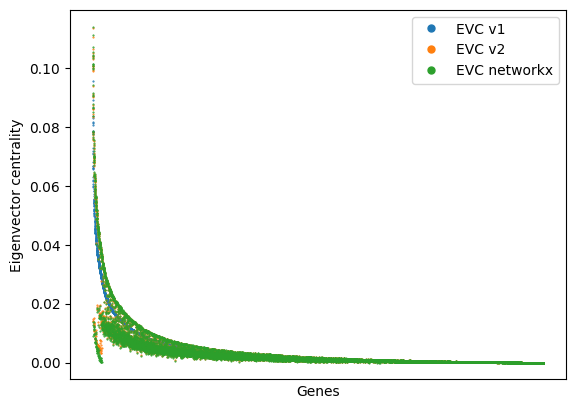

In [196]:
# compare HC with and without Reactome
df[['EVC v1', 'EVC v2', 'EVC networkx']].plot(style='o', ms=0.5)
plt.xlabel('Genes')
plt.xticks([])
plt.ylabel('Eigenvector centrality')
plt.legend(fontsize=10, markerscale=10)